In [3]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.path as mpath
import matplotlib.patches as patches
import matplotlib.cm as cm
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import cartopy.mpl.gridliner as gridliner
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", message="All-NaN slice encountered")
%matplotlib inline
import time
import cftime
import seaborn as sns
import calendar
import datetime
from pyproj import Proj, transform


In [4]:
path_cdr='/storage2/tkyeimiah/CDR/'

In [ ]:
''' files = glob.glob(path_cdr + 'seaice*.nc')
sorted_files = sorted(files)

cdr = xr.open_mfdataset(sorted_files, engine='h5netcdf', combine='nested', concat_dim='tdim')
cdr_CT=cdr.cdr_seaice_conc_monthly
cdr_CT.time.values
''';

In [5]:
cdr=xr.open_dataset(path_cdr+'cdr_CT.nc')
cdr

<xarray.Dataset>
Dimensions:                  (tdim: 372, x: 304, y: 448)
Coordinates:
    time                     (tdim) datetime64[ns] ...
    xgrid                    (x) float32 ...
    ygrid                    (y) float32 ...
Dimensions without coordinates: tdim, x, y
Data variables:
    cdr_seaice_conc_monthly  (tdim, y, x) float32 ...

In [6]:
cdr_CT=cdr.cdr_seaice_conc_monthly

In [7]:
cdr_CT

<xarray.DataArray 'cdr_seaice_conc_monthly' (tdim: 372, y: 448, x: 304)>
[50663424 values with dtype=float32]
Coordinates:
    time     (tdim) datetime64[ns] 1990-01-01 1990-02-01 ... 2020-12-01
    xgrid    (x) float32 -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
    ygrid    (y) float32 5.838e+06 5.812e+06 5.788e+06 ... -5.312e+06 -5.338e+06
Dimensions without coordinates: tdim, y, x
Attributes:
    long_name:            NOAA/NSIDC Climate Data Record of Passive Microwave...
    ancillary_variables:  stdev_of_cdr_seaice_conc_monthly qa_of_cdr_seaice_c...
    flag_meanings:        pole_hole lakes coastal land_mask missing_data
    flag_values:          [251 252 253 254 255]
    standard_name:        sea_ice_area_fraction
    datum:                +ellps=urn:ogc:def:crs:EPSG::4326
    units:                1
    reference:            https://nsidc.org/data/g02202/versions/4/
    grid_mapping:         projection
    valid_range:          [  0 100]

In [14]:
# Extract the x and y grid coordinates
xgrid = cdr_CT.xgrid.values
ygrid = cdr_CT.ygrid.values

# Create a meshgrid of x and y coordinates
x, y = np.meshgrid(xgrid, ygrid)

# Define the projection used by the xgrid and ygrid (EPSG:3411)
proj_stereo = Proj(init='EPSG:3411')

# Define the projection for latitude and longitude
proj_latlon = Proj(proj='latlong', datum='WGS84')

# Transform the grid coordinates to latitude and longitude
lon, lat = transform(proj_stereo, proj_latlon, x, y)

# Create DataArrays for lon and lat to use xarray's slicing
lon_da = xr.DataArray(lon, dims=('y', 'x'))
lat_da = xr.DataArray(lat, dims=('y', 'x'))

# Define the Labrador coast boundaries
lon_min, lon_max = -73, -45  # Converted from 287 to 315 degrees to -73 to -45 degrees
lat_min, lat_max = 51, 69

# Subset the data using the domain mask
domain_mask = (lon_da >= lon_min) & (lon_da <= lon_max) & (lat_da >= lat_min) & (lat_da <= lat_max)
cdr_CT_subset = cdr_CT.where(domain_mask, drop=True)
cdr_CT_domain = cdr_CT_subset.where(cdr_CT_subset <= 1)
# Subset lon and lat accordingly
lon_subset = lon_da.where(domain_mask, drop=True)
lat_subset = lat_da.where(domain_mask, drop=True)

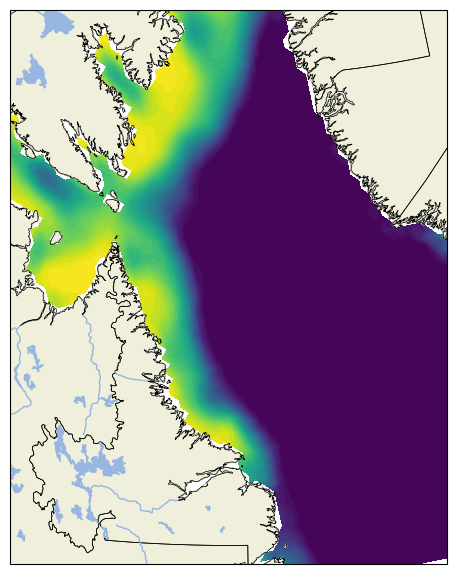

In [30]:
fig = plt.figure(figsize=(6, 7.2))
x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
ax = plt.subplot(1,1, 1,projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    
ax.coastlines(zorder=2)
ax.add_feature(cfeature.LAND, zorder=2)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5,  zorder=2)
ax.add_feature(cfeature.LAKES.with_scale('10m'),  zorder=2)
ax.add_feature(cfeature.RIVERS.with_scale('10m'),  zorder=2)
ax.set_extent([x0, x1, y0, y1])
#ax.text(0,1.05,name[i], transform=ax.transAxes, fontsize=10)
ax.contourf(lon_subset, lat_subset,  cdr_CT_domain[100], levels=45, transform=ccrs.PlateCarree(), )